In [14]:
!pip install python-dotenv
!pip install newsdataapi
!pip install openai
!pip install matplotlib
!pip install wordcloud

In [15]:
from dotenv import load_dotenv
from newsdataapi import NewsDataApiClient
from collections import Count
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import openai
import requests
import time


In [7]:
load_dotenv()

open_ai_api_key = os.getenv('OPENAI_API_KEY')
newsdata_api_key = os.getenv('NEWSIO_API_KEY')

newsdata_api = NewsDataApiClient(apikey=newsdata_api_key)

In [4]:
# Fetches the latest news articles based on the provided query
def get_news_articles(query):
    url = f'https://newsdata.io/api/1/latest?apikey={newsdata_api_key}&q={query}&language=en'
    response = requests.get(url)
    if (response.status_code == 200):
        return response.json()
    else:
        print("Error fetching articles.")
        return None

# Prompt the user to enter a query term for the news search
user_query = input("Enter a query for news articles: ")

data = get_news_articles(user_query)

Enter a query for news articles: Hamas


In [20]:
# Extract relevant article information for each article
article_info_list = [
    {
        'title': article['title'],
        'source_url': article['source_url'],
        'description': article['description'],
        'pub_date': article['pubDate']
    }
    for article in data['results'] if article.get('description')
]

# Convert the list of dictionaries to a DataFrame
article_info_df = pd.DataFrame(article_info_list)

# Display the DataFrame
print(article_info_df)

# Count the number of rows in the DataFrame
row_count = article_info_df.shape[0]
print("Row count:", row_count)

[{'title': 'Netanyahu aide arrested over Gaza hostage talks stories', 'source_url': 'https://www.recentlyheard.com', 'description': 'Arrests. Categorised paperwork. And suspected leaks that will have harmed efforts to free hostages held by Hamas so as, critics say, to offer Israeli Prime Minister Benjamin Netanyahu public cowl for failing to comply with a cease-fire deal. Netanyahu was engulfed in scandal Monday over a case involving one among his aides that has despatched ... Read moreThe post Netanyahu aide arrested over Gaza hostage talks stories appeared first on RecentlyHeard: Timely Updates on News, Politics, and Stories Unfolding Across the United States.', 'pub_date': '2024-11-05 07:18:35'}, {'title': 'TRUMP CLINGS TO CONSPIRACIES; HARRIS VISITS MICH. CHURCH', 'source_url': 'https://dothaneagle.com', 'description': 'LITITZ, Pa. — Donald Trump delivered a profane and conspiracy-laden speech two days before Tuesday\'s presidential election, talking about reporters being shot and 

In [21]:
# Set openai api key
openai.apikey = open_ai_api_key

client = openai.OpenAI()

# Function to analyze the sentiment of a given text
def get_sentiment(text):
    prompt = f"Analyze the sentiment of the following text as positive, negative, or neutral. Respond with a single word: {text}"
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        max_tokens=10
    )
    return response.choices[0].message.content.strip()

# Initialize an empty list to store sentiments
sentiments = []

# Determine the number of articles to process (up to a maximum of 10)
num_articles = min(10, len(article_info_df))

# Iterate over the selected articles
for i in range(num_articles):
    # Get sentiment of the article's description
    article = article_info_df.iloc[i]
    sentiment = get_sentiment(article['description'])
    sentiments.append(sentiment)
    
    # Pause after every 3 requests to respect the API rate limit
    if (i + 1) % 3 == 0:
        time.sleep(61)

print(sentiments)

['Negative', 'Negative', 'Positive', 'Positive', 'Positive', 'Negative', 'Neutral', 'Positive', 'Negative', 'Negative']


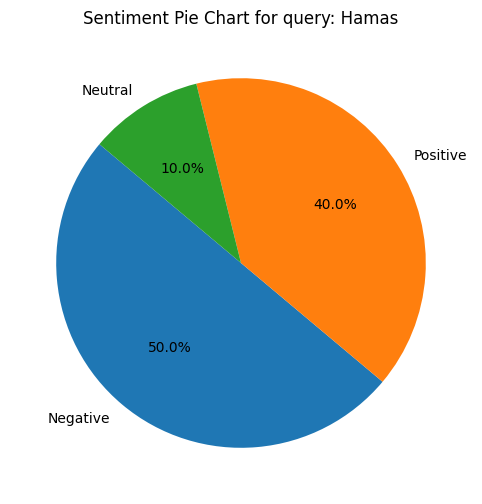

In [22]:
# Count occurrences of each keyword
keyword_counts = Counter(sentiments)

# Separate the data into labels and sizes for the pie chart
labels = keyword_counts.keys()
sizes = keyword_counts.values()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title(f'Sentiment Pie Chart for query: {user_query}')
plt.show()

In [24]:
# Concatenate all article descriptions into a single string, separated by spaces
all_descriptions = " ".join(article['description'] for article in article_info_list)

# Function to summarize a given text
def summarize_text(text):
    prompt = f"Summarize the following news descriptions into a concise overview: {text}"
    response = client.chat.completions.create(
        model="gpt-4o-mini", 
        messages=[{"role": "user", "content": prompt}],
        max_tokens=200
    )
    return response.choices[0].message.content.strip()

# Generate a summary of all article descriptions
overall_summary = summarize_text(all_descriptions)

# Print the final summary of the news articles
print("Overall Summary of News Articles:\n")
print(overall_summary)

Overall Summary of News Articles:


Israeli Prime Minister Benjamin Netanyahu is embroiled in a scandal following the arrest of one of his aides as part of an investigation into a suspected security breach that may have jeopardized efforts to negotiate a hostage deal related to the ongoing conflict with Hamas. Critics argue that this situation provides Netanyahu with political cover amidst claims of his failure to agree to a cease-fire. In unrelated news, Donald Trump delivered a controversial speech prior to the presidential election, and notable figures in Israel received prestigious awards. Additionally, companies Coloplast and Vestas reported positive financial outcomes, while immigration issues continue to leave many individuals uncertain about their future.


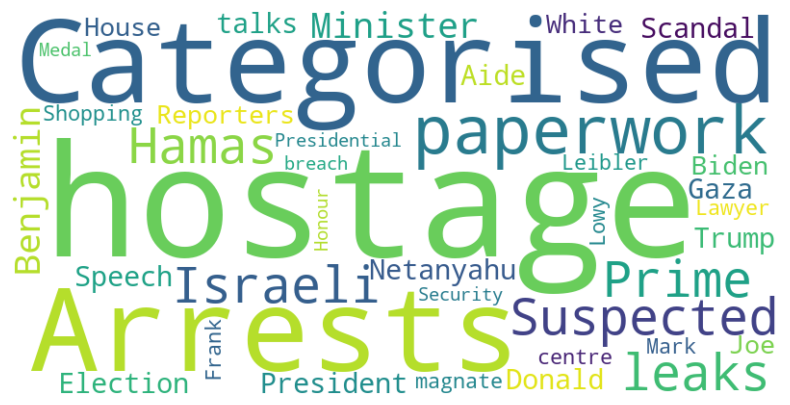

In [25]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(keywords)
plt.figure(figsize=(10, 5))

# Display the generated word cloud image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()